# Final Project Notebook



#### <span style="background:yellow">Be sure to save your work early and often!</span>

#### Feel free to add more cells as necessary

<img src="../images/Specific_Project_1.png" />

---
## Grading Note: 

The Final Project is worth 15% of the Final Grade. The points values in this notebook are there to indicate the _relative worth_ of each _part_ of this project, not the worth of the project relative to the rest of the course, which is fixed at 15%

Steps 2-4 are each worth 25% of the Final Project grade, with Steps 1 and 5 togther worth the final 25%

---

# Step 1: Design and Create a Database Store

Design and create your database storage in the GCP Console. This database (shown in yellow in the figure above) will be the source for all of your Data Analytics, including the tables and visualizations. 

Consider what kind of data you will need to store by reviewing the JSON files you created in the [module 5 exercise](../../module5/exercises/Module5_Exercise.ipynb) and the data returned by the GCP NLP API in the [module 6 lab](../../module6/labs/Google_NLP_API_Lab.ipynb). 


#### What type of datastore did you choose to use? Why?
**(2 pt)**

#### Database Store Artifact 

Provide an artifact showing which columns (SQL) or properties (NoSQL) you chose to include in your Database Store. The recommended artifact is a screenshot, but you may choose to query your DB (if you are using SQL) from Jupyter as well

**(5 pts)**

In [1]:
#----
# Your Query or Screenshot here
#----

import getpass
#mypasswd = 'PASSWORD'
mypasswd = getpass.getpass()

········


In [2]:
import psycopg2
connection = psycopg2.connect(database = 'final_data', 
                              user = 'postgres', 
                              host = '173.255.114.235',
                              password = mypasswd)
with connection, connection.cursor() as cursor:
    cursor.execute("""
        SELECT column_name 
        FROM information_schema.columns 
        WHERE table_name = 'final_data';
    """)
    columns = [row[0] for row in cursor.fetchall()]
    print("Columns:", columns)

    cursor.execute("SELECT * FROM final_data;")
    results = cursor.fetchall()

Columns: ['date', 'id', 'title', 'url', 'summary', 'subreddit']


---
# Step 2: Scraping Reddit RSS into GCP Buckets

### 2.1 Create a new GCP Bucket

Create a new bucket in the GCP Console (or with gcloud CLI), and name it `final-project-{MU SSO ID}`

### 2.2 Building RSS Scraping Code
Update your code from the [module 5 exercise](../../module5/exercises/Module5_Exercise.ipynb) to grab _at least_ 50 JSON files in a single run of the script. You may also need to update the code to keep or generate new data about each RSS entry for your Database store designed in Step 1

#### Paste your script into the cell below:
**(7 pts)**

In [ ]:
import requests
import feedparser
import json
import psycopg2
from bs4 import BeautifulSoup
from bs4.element import Comment
from google.cloud import storage
from datetime import datetime, timezone
import re
import getpass

# Prompt for PostgreSQL password
mypasswd = getpass.getpass(prompt="Enter your PostgreSQL password: ")

# PostgreSQL connection configuration
DB_CONFIG = {
    "database": "final_data",
    "user": "postgres",
    "host": "173.255.114.235",
    "password": mypasswd
}

def tag_visible(element):
    """
    Filter visible HTML elements from BeautifulSoup parsed content.
    """
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True

def text_from_html(body):
    """
    Extract visible text from HTML content.
    """
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.find_all(string=True)
    visible_texts = filter(tag_visible, texts)
    return u" ".join(t.strip() for t in visible_texts)

def sanitize_filename(title):
    """
    Sanitize the title to create a valid filename by removing invalid characters.
    """
    return re.sub(r'[\\/*?:"<>|]', '_', title)

def upload_to_gcp_bucket(bucket_name, file_name, data):
    """
    Upload data to a GCP bucket as a JSON file.
    """
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(file_name)
        blob.upload_from_string(data, content_type='application/json')
        print(f"Uploaded {file_name} to bucket {bucket_name}")
    except Exception as e:
        print(f"Failed to upload {file_name} to bucket {bucket_name}: {e}")

def save_to_database(connection, data):
    """
    Save RSS entry data to the PostgreSQL database.
    """
    try:
        with connection, connection.cursor() as cursor:
            # Create table if it doesn't exist
            cursor.execute("""
            CREATE TABLE IF NOT EXISTS rss_entries (
                id SERIAL PRIMARY KEY,
                title TEXT,
                url TEXT,
                summary TEXT,
                pub_date TIMESTAMP,
                created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
            """)

            # Insert data
            cursor.execute("""
            INSERT INTO rss_entries (title, url, summary, pub_date)
            VALUES (%s, %s, %s, %s)
            """, (data["title"], data["url"], data["summary"], data["date"]))

            print(f"Saved entry to database: {data['title']}")
    except Exception as e:
        print(f"Failed to save entry to database: {e}")

def fetch_rss_with_headers(url):
    """
    Fetch the RSS feed with appropriate headers to ensure proper response from the server.
    """
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        feed = feedparser.parse(response.text)
        if feed['bozo'] == 1:
            raise Exception(f"Parsing Error: {feed['bozo_exception']}")
        return feed
    else:
        raise Exception(f"Failed to fetch RSS feed. HTTP Status: {response.status_code}")

def custom_json_serializer(obj):
    """
    Custom JSON serializer for objects not serializable by default, like datetime.
    """
    if isinstance(obj, datetime):
        return obj.isoformat()
    raise TypeError(f"Type {type(obj)} not serializable")

# Main script
if __name__ == "__main__":
    # Define the RSS feed URL
    reddit_rss_url = 'https://www.reddit.com/new/.rss?sort=new'
    bucket_name = 'final-project-jsmm8'

    # Connect to the database
    try:
        connection = psycopg2.connect(**DB_CONFIG)

        # Fetch RSS feed
        try:
            rss_feed = fetch_rss_with_headers(reddit_rss_url)
            print(f"Fetched {len(rss_feed['items'])} items from the feed.")
        except Exception as e:
            print(f"Failed to fetch or parse RSS feed: {e}")
            rss_feed = {"items": []}

        # Process each RSS item
        for item in rss_feed['items']:
            try:
                # Extract and structure data
                date_parsed = item.get("date_parsed")
                if date_parsed and len(date_parsed) >= 6:
                    try:
                        date = datetime(*date_parsed[:6], tzinfo=timezone.utc)
                    except Exception as e:
                        print(f"Error parsing date: {e}. Using current datetime.")
                        date = datetime.now(timezone.utc)
                else:
                    date = datetime.now(timezone.utc)

                data = {
                    "title": item.get("title", "No Title"),
                    "url": item.get("link", "No URL"),
                    "summary": text_from_html(item.get("summary", "No Summary")),
                    "date": date
                }

                # Generate a unique filename
                sanitized_title = sanitize_filename(data["title"][:50])
                file_name = f"reddit_{datetime.now().strftime('%Y%m%d%H%M%S')}_{sanitized_title}.json"

                # Convert the data to JSON format with a custom serializer
                json_data = json.dumps(data, default=custom_json_serializer)

                # Upload the file to GCP bucket
                upload_to_gcp_bucket(bucket_name, file_name, json_data)

                # Save the entry to the database
                save_to_database(connection, data)

            except Exception as e:
                print(f"Error processing item: {e}")
    except Exception as e:
        print(f"Failed to connect to the database: {e}")
    finally:
        if 'connection' in locals() and connection:
            connection.close()
            print("Database connection closed.")

### 2.3 Run Your RSS Scraping Script

Copy your code to your VM, and run it

### 2.4 Listing Bucket Contents

Use the Python SDK for GCP to list the contents of your bucket. There should be at least 50 JSON files present in your bucket

#### Paste the code you used to do this in the cell below:
**(3 pts)**

In [ ]:
#----
# Your list bucket code here
#----

from google.cloud import storage

def list_bucket_contents(bucket_name):
    """
    List all the JSON files in a specified Google Cloud Storage bucket.

    Args:
        bucket_name (str): The name of the bucket.
    """
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)

        blobs = bucket.list_blobs()
        print(f"Contents of bucket '{bucket_name}':")
        json_files = []
        for blob in blobs:
            if blob.name.endswith(".json"):
                json_files.append(blob.name)

        if json_files:
            print(f"Found {len(json_files)} JSON files:")
            for file in json_files:
                print(f" - {file}")
        else:
            print("No JSON files found in the bucket.")

    except Exception as e:
        print(f"An error occurred while listing the bucket contents: {e}")

bucket_name = 'final-project-jsmm8'
list_bucket_contents(bucket_name)


#### Take a screenshot of the output, and upload it to `module7/exercises`, and load it into the cell below:
**(3 pts)**

<img src="./Reddit_contents.png" alt="Your screenshot is MISSING" />

---
# Step 3: Processing JSON with the NLP API

### 3.1 Building NLP Processing Code
Build a Python script that takes in the name of your bucket, and the authentication necessary for your database store and:

1. Loads your JSON files into memory
2. Runs NLP Sentiment Analysis on each JSON file
3. Processes the JSON data and NLP sentiment analysis
4. Inserts the releveant (processed) data into your Database Store

**Paste the script into the cell below:**

**(8 pts)**

In [ ]:
#----
# Your JSON processing code here
#----

import os
import json
import psycopg2
from google.cloud import storage
from textblob import TextBlob
import getpass

def load_json_files(bucket_name):
    """
    Loads JSON files from the specified GCP bucket into memory.
    Args:
        bucket_name (str): Name of the GCP bucket.
    Returns:
        list of dict: List of JSON objects loaded from files.
    """
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)

        data_list = []
        for blob in bucket.list_blobs():
            if blob.name.endswith(".json"):
                content = blob.download_as_text()
                data = json.loads(content)
                data_list.append(data)
                print(f"Loaded file: {blob.name}")
        return data_list

    except Exception as e:
        print(f"Error loading files from bucket {bucket_name}: {e}")
        return []

def analyze_sentiment(text):
    """
    Performs sentiment analysis on the given text using TextBlob.
    Args:
        text (str): Text to analyze.
    Returns:
        tuple: Polarity and subjectivity scores.
    """
    if not text:
        return 0.0, 0.0
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

def process_and_store_data(data_list, db_config):
    """
    Processes JSON data, performs NLP sentiment analysis, and stores the results in a PostgreSQL database.
    Args:
        data_list (list of dict): List of JSON objects.
        db_config (dict): Database connection configuration.
    """
    connection = None
    try:
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor()
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS processed_data (
            id SERIAL PRIMARY KEY,
            title TEXT,
            url TEXT,
            summary TEXT,
            pub_date TIMESTAMP,
            sentiment_polarity REAL,
            sentiment_subjectivity REAL,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
        """)

        for data in data_list:
            title = data.get("title", "")
            url = data.get("url", "")
            summary = data.get("summary", "")
            pub_date = data.get("date")
            polarity, subjectivity = analyze_sentiment(summary)

            cursor.execute("""
            INSERT INTO processed_data (
                title, url, summary, pub_date, sentiment_polarity, sentiment_subjectivity
            ) VALUES (%s, %s, %s, %s, %s, %s)
            """, (title, url, summary, pub_date, polarity, subjectivity))
            print(f"Processed and inserted data for: {title}")
        connection.commit()
    except Exception as e:
        print(f"An error occurred during processing: {e}")
    finally:
        if connection:
            connection.close()
            print("Database connection closed.")

if __name__ == "__main__":
    bucket_name = input("Enter the name of your GCP bucket: ")
    db_config = {
        "database": "final_data",
        "user": "postgres",
        "host": "173.255.114.235",
        "password": getpass.getpass("Enter your PostgreSQL password: "),
    }

    json_data_list = load_json_files(bucket_name)

    if not json_data_list:
        print("No JSON files found in the bucket or an error occurred.")
    else:
        process_and_store_data(json_data_list, db_config)

### 3.2 Query your Database Store

Build and run the code necessary to query your Database Store in Python3. 

#### Paste the code to query your Database in Python in the cell below:
**(3 pts)**

In [3]:
#----
# Your DB Query code here
#----

import psycopg2
from psycopg2.extras import RealDictCursor
import getpass

def query_database(db_config, query):
    """
    Connects to a PostgreSQL database and executes a query.

    Args:
        db_config (dict): Database connection configuration.
        query (str): SQL query to execute.

    Returns:
        list: Query results as a list of dictionaries.
    """
    connection = None
    try:
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
        results = cursor.fetchall()

        print(f"Query executed successfully. Retrieved {len(results)} rows.")
        return results
    except Exception as e:
        print(f"An error occurred while querying the database: {e}")
        return []
    finally:
        if connection:
            connection.close()
            print("Database connection closed.")

if __name__ == "__main__":
    db_config = {
        "database": "final_data",
        "user": "postgres",
        "host": "173.255.114.235",
        "password": getpass.getpass("Enter your PostgreSQL password: "),
    }
    query = """
    SELECT title, url, summary, pub_date, sentiment_polarity, sentiment_subjectivity
    FROM processed_data
    ORDER BY pub_date DESC
    LIMIT 10;
    """

    results = query_database(db_config, query)
    if results:
        print("Query Results:")
        for row in results:
            print(row)

Enter your PostgreSQL password: ········
Query executed successfully. Retrieved 10 rows.
Database connection closed.
Query Results:
RealDictRow([('title', 'How do I go live on my phone?'), ('url', 'https://www.reddit.com/r/Tiktokhelp/comments/1harbev/how_do_i_go_live_on_my_phone/'), ('summary', '      It sends me to this every time.  submitted by /u/Correct-Bathroom9116 to r/Tiktokhelp   [link]  [comments] '), ('pub_date', datetime.datetime(2024, 12, 10, 2, 25, 30)), ('sentiment_polarity', 0.0), ('sentiment_subjectivity', 0.0)])
RealDictRow([('title', '20 ft. Giant-Sized LED Santa Christmas Airblown® Inflatable is in stock at Home Depot for $199.00 (Less than MSRP) (originally $299.00)'), ('url', 'https://www.reddit.com/r/ChristmasRestocks/comments/1harbeq/20_ft_giantsized_led_santa_christmas_airblown/'), ('summary', 'View current status at https://www.trackalacker.com/products/showcase/20-ft-giant-sized-led-santa...  As of 12/09/24 09:25 PM EST  /u/TrackaLackerBot r/ChristmasRestocks 

#### Provide a screenshot of the output (if necessary):

**Note**: If you used `psycopg2` or `SQLAlchemy` to query a SQL database in the cell above, you can skip the screenshot

**(2 pts)**

<img src="./" alt="Your screenshot is MISSING" />

---
# Step 4: Programmatic Data Analysis


### 4.1 Building a Tabularized Visualization

Write the code necessary to process the data in your Database store into a meaningful analytical tablular visualization that gives analytical insights into the data you scraped from Reddit. 

#### Paste the code you used into the cell below:
**(3 pts)**

In [4]:
#----
# Your table code here
#---

import psycopg2
import pandas as pd
from psycopg2.extras import RealDictCursor
import getpass
from collections import Counter

def fetch_data_from_database(db_config, query):
    """
    Fetches data from the PostgreSQL database.

    Args:
        db_config (dict): Database connection configuration.
        query (str): SQL query to execute.

    Returns:
        pd.DataFrame: Query results as a pandas DataFrame.
    """
    try:
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
        results = cursor.fetchall()

        df = pd.DataFrame(results)
        print("Data fetched successfully.")
        return df
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return pd.DataFrame()
    finally:
        if 'connection' in locals() and connection:
            connection.close()
            print("Database connection closed.")

def analyze_data(df):
    """
    Analyzes the data and provides meaningful insights.

    Args:
        df (pd.DataFrame): DataFrame containing the fetched data.
    """
    if df.empty:
        print("No data to analyze.")
        return

    print("Basic Sentiment Analysis:")
    print(df[['sentiment_polarity', 'sentiment_subjectivity']].describe())

    df['pub_date'] = pd.to_datetime(df['pub_date'])
    df['date'] = df['pub_date'].dt.date
    daily_sentiment = df.groupby('date').agg({
        'sentiment_polarity': 'mean',
        'sentiment_subjectivity': 'mean'
    }).reset_index()

    print("\nDaily Sentiment Trends (First 10 Days):")
    print(daily_sentiment.head(10))
    all_words = ' '.join(df['summary']).split()
    word_counts = Counter(all_words)
    most_common_words = pd.DataFrame(word_counts.most_common(10), columns=['Word', 'Frequency'])

    print("\nMost Common Words in Summaries:")
    print(most_common_words)

if __name__ == "__main__":
    db_config = {
        "database": "final_data",
        "user": "postgres",
        "host": "173.255.114.235",
        "password": getpass.getpass("Enter your PostgreSQL password: "),
    }

    query = """
    SELECT title, url, summary, pub_date, sentiment_polarity, sentiment_subjectivity
    FROM processed_data;
    """

    df = fetch_data_from_database(db_config, query)
    analyze_data(df)

Enter your PostgreSQL password: ········
Data fetched successfully.
Database connection closed.
Basic Sentiment Analysis:
       sentiment_polarity  sentiment_subjectivity
count           50.000000               50.000000
mean             0.038136                0.271033
std              0.192957                0.281634
min             -0.300000                0.000000
25%              0.000000                0.000000
50%              0.000000                0.270281
75%              0.029738                0.463065
max              1.000000                1.000000

Daily Sentiment Trends (First 10 Days):
         date  sentiment_polarity  sentiment_subjectivity
0  2024-12-10            0.038136                0.271033

Most Common Words in Summaries:
         Word  Frequency
0          to        100
1         the         90
2         and         89
3           I         82
4           a         59
5      [link]         50
6  [comments]         50
7          of         43
8         for

#### Provide a screenshot of the output (if necessary)
**(3 pts)**

If you ran your code in a VM, take a screenshot of the resulting tablular visualization and provide it here.

<img src="./" alt="Your screenshot is MISSING" />

### A Few more Analysis

In [5]:
import psycopg2
from psycopg2.extras import RealDictCursor
from textblob import TextBlob
import getpass

def classify_sentiment(polarity):
    """
    Classifies sentiment as positive, negative, or neutral based on polarity.

    Args:
        polarity (float): Sentiment polarity score from TextBlob.

    Returns:
        str: Sentiment classification ('positive', 'negative', 'neutral').
    """
    if polarity > 0.05:
        return "positive"
    elif polarity < -0.05:
        return "negative"
    else:
        return "neutral"

def query_and_classify_sentiment(db_config):
    """
    Queries the database for processed data and classifies sentiment as positive, negative, or neutral.

    Args:
        db_config (dict): Database connection configuration.

    Returns:
        list: Query results with sentiment classification added.
    """
    query = """
    SELECT title, url, summary, pub_date, sentiment_polarity, sentiment_subjectivity
    FROM processed_data;
    """
    connection = None
    try:
        # Connect to the database
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor(cursor_factory=RealDictCursor)

        # Execute the query
        cursor.execute(query)
        results = cursor.fetchall()

        # Classify sentiment for each row
        for row in results:
            row["sentiment_class"] = classify_sentiment(row["sentiment_polarity"])

        print(f"Query executed successfully. Classified sentiment for {len(results)} rows.")
        return results
    except Exception as e:
        print(f"An error occurred: {e}")
        return []
    finally:
        if connection:
            connection.close()
            print("Database connection closed.")

if __name__ == "__main__":
    # Database configuration
    db_config = {
        "database": "final_data",
        "user": "postgres",
        "host": "173.255.114.235",
        "password": getpass.getpass("Enter your PostgreSQL password: "),
    }

    # Query and classify sentiment
    results = query_and_classify_sentiment(db_config)

    # Display classified results
    if results:
        print("\nClassified Sentiment Results:")
        for row in results[:10]:
            print(f"Title: {row['title']}")
            print(f"Summary: {row['summary']}")
            print(f"Polarity: {row['sentiment_polarity']}")
            print(f"Sentiment: {row['sentiment_class']}")
            print("-" * 50)


Enter your PostgreSQL password: ········
Query executed successfully. Classified sentiment for 50 rows.
Database connection closed.

Classified Sentiment Results:
Title: Played Labyrinth today
Summary:       The best part was triggering the Brick Keeper Multi-ball while in the Bog of Eternal Stench. I got to do a fart solo over Bowles musical number! That song sounds like shit, so the farts really added to the experience!  submitted by /u/TrainWreckInnaBarn to r/pinball   [link]  [comments] 
Polarity: 0.2625
Sentiment: positive
--------------------------------------------------
Title: Act 2 spirit item
Summary: Is there an item to increase spirit in act 2 like there is in acts 1 and 3? I saw somewhere it is in Gold Tomb in Lost City, but it wasn't there. I saw other people asking but never getting response or confirmation that it really is in Gold Tomb.  /u/Cone01 r/PathOfExile2 [link] [comments]
Polarity: 0.0375
Sentiment: neutral
--------------------------------------------------
Tit

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import psycopg2
from psycopg2.extras import RealDictCursor
import getpass

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Database configuration
db_config = {
    "database": "final_data",
    "user": "postgres",
    "host": "173.255.114.235",
    "password": getpass.getpass("Enter your PostgreSQL password: "),
}

def fetch_posts(db_config):
    """
    Fetches posts (processed data) from the PostgreSQL database.
    Args:
        db_config (dict): Database connection configuration.
    Returns:
        list: List of posts with relevant fields.
    """
    query = """
    SELECT id, summary AS processed_body
    FROM processed_data;
    """
    try:
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
        posts = cursor.fetchall()
        print(f"Fetched {len(posts)} posts from the database.")
        return posts
    except Exception as e:
        print(f"Error fetching posts: {e}")
        return []
    finally:
        if connection:
            connection.close()
            print("Database connection closed.")

def analyze_sentiment(posts):
    """
    Analyzes sentiment for each post using VADER and prints the results.
    Args:
        posts (list): List of posts with the 'processed_body' field.
    """
    for post in posts:
        body = post['processed_body']
        sentiment_scores = analyzer.polarity_scores(body)

        print(f"Negative: {sentiment_scores['neg']}")
        print(f"Neutral: {sentiment_scores['neu']}")
        print(f"Positive: {sentiment_scores['pos']}")
        print(f"Compound: {sentiment_scores['compound']}")
        print(f"Body: {body}\n")

if __name__ == "__main__":
    # Fetch posts from the database
    posts = fetch_posts(db_config)

    if posts:
        # Analyze sentiment and print results
        analyze_sentiment(posts)
    else:
        print("No posts to analyze.")


Enter your PostgreSQL password: ········
Fetched 50 posts from the database.
Database connection closed.
Negative: 0.12
Neutral: 0.731
Positive: 0.149
Compound: 0.1739
Body:       The best part was triggering the Brick Keeper Multi-ball while in the Bog of Eternal Stench. I got to do a fart solo over Bowles musical number! That song sounds like shit, so the farts really added to the experience!  submitted by /u/TrainWreckInnaBarn to r/pinball   [link]  [comments] 

Negative: 0.029
Neutral: 0.889
Positive: 0.083
Compound: 0.2732
Body: Is there an item to increase spirit in act 2 like there is in acts 1 and 3? I saw somewhere it is in Gold Tomb in Lost City, but it wasn't there. I saw other people asking but never getting response or confirmation that it really is in Gold Tomb.  /u/Cone01 r/PathOfExile2 [link] [comments]

Negative: 0.0
Neutral: 1.0
Positive: 0.0
Compound: 0.0
Body: I know that Ariane 6 can have a Sylda but is also a Speltra available?  /u/Meamier r/esa [link] [comments]


In [7]:
import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import getpass

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Database configuration
db_config = {
    "database": "final_data",
    "user": "postgres",
    "host": "173.255.114.235",
    "password": getpass.getpass("Enter your PostgreSQL password: "),
}

def fetch_data_as_dataframe(db_config):
    """
    Fetches processed data from PostgreSQL database and loads it into a pandas DataFrame.
    Args:
        db_config (dict): Database connection configuration.
    Returns:
        pd.DataFrame: DataFrame containing the processed data.
    """
    query = """
    SELECT id, summary AS processed_body
    FROM processed_data;
    """
    try:
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
        results = cursor.fetchall()
        df = pd.DataFrame(results)
        print(f"Fetched {len(df)} rows from the database.")
        return df
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return pd.DataFrame()
    finally:
        if connection:
            connection.close()
            print("Database connection closed.")

def add_sentiment_scores(df):
    """
    Adds sentiment scores (pos, neg, neu) to the DataFrame using VADER Sentiment Analyzer.
    Args:
        df (pd.DataFrame): DataFrame containing the processed body text.
    Returns:
        pd.DataFrame: Updated DataFrame with sentiment scores.
    """
    if 'processed_body' not in df.columns:
        print("Error: 'processed_body' column not found in DataFrame.")
        return df

    print("Calculating sentiment scores...")
    df['pos'] = df['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['pos'] if isinstance(x, str) else 0)
    df['neg'] = df['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['neg'] if isinstance(x, str) else 0)
    df['neu'] = df['processed_body'].apply(lambda x: analyzer.polarity_scores(x)['neu'] if isinstance(x, str) else 0)

    print("Sentiment scores added to the DataFrame.")
    return df

if __name__ == "__main__":
    # Fetch data as a DataFrame
    df_machine_learning = fetch_data_as_dataframe(db_config)

    if not df_machine_learning.empty:
        # Add sentiment scores to the DataFrame
        df_machine_learning = add_sentiment_scores(df_machine_learning)

        # Display the first few rows with sentiment scores
        print(df_machine_learning.head())
    else:
        print("No data fetched from the database.")


Enter your PostgreSQL password: ········
Fetched 50 rows from the database.
Database connection closed.
Calculating sentiment scores...
Sentiment scores added to the DataFrame.
   id                                     processed_body    pos    neg    neu
0   1        The best part was triggering the Brick K...  0.149  0.120  0.731
1   2  Is there an item to increase spirit in act 2 l...  0.083  0.029  0.889
2   3  I know that Ariane 6 can have a Sylda but is a...  0.000  0.000  1.000
3   4  /u/Ok_Strength_605 r/TwentyOnePilotsLyrics [li...  0.000  0.000  1.000
4   5   /u/Spare_Truck_2813 r/Digicore [link] [comments]  0.000  0.000  1.000


### 4.2 Building a Graphical Visualization

Use `matplotlib`, `seaborn`, or a similar library to build a graphical visualization from the data in your analytical database store.

#### Paste the code you used into the cell below:
**(3 pts)**

Enter your PostgreSQL password: ········
Data fetched successfully.
Database connection closed.


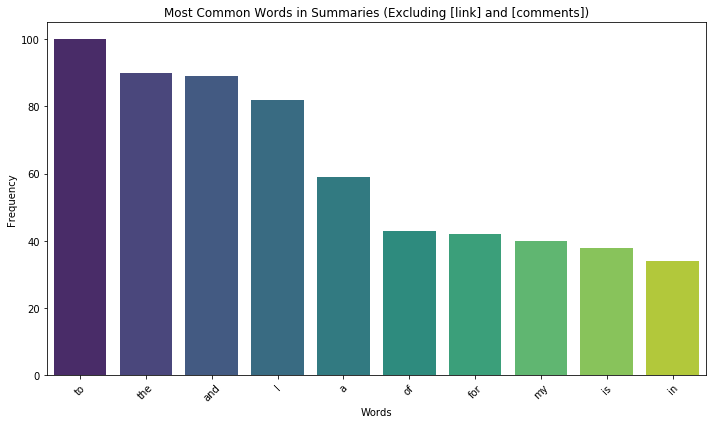

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from psycopg2.extras import RealDictCursor
import pandas as pd
import psycopg2
import getpass
from collections import Counter

def fetch_data_from_database(db_config, query):
    """
    Fetches data from the PostgreSQL database.

    Args:
        db_config (dict): Database connection configuration.
        query (str): SQL query to execute.

    Returns:
        pd.DataFrame: Query results as a pandas DataFrame.
    """
    try:
        connection = psycopg2.connect(**db_config)
        cursor = connection.cursor(cursor_factory=RealDictCursor)
        cursor.execute(query)
        results = cursor.fetchall()

        df = pd.DataFrame(results)
        print("Data fetched successfully.")
        return df
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")
        return pd.DataFrame()
    finally:
        if 'connection' in locals() and connection:
            connection.close()
            print("Database connection closed.")

def visualize_data(df):
    """
    Generates visualizations from the data, excluding specific words.

    Args:
        df (pd.DataFrame): DataFrame containing the fetched data.
    """
    if df.empty:
        print("No data to visualize.")
        return

    # Generate the most common words bar plot
    all_words = ' '.join(df['summary']).split()
    word_counts = Counter(all_words)

    # Exclude '[link]' and '[comments]'
    excluded_words = {'[link]', '[comments]'}
    filtered_word_counts = {word: count for word, count in word_counts.items() if word not in excluded_words}

    # Convert to a DataFrame and select the top 10 most common words
    most_common_words = pd.DataFrame(
        Counter(filtered_word_counts).most_common(10),
        columns=['Word', 'Frequency']
    )

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Word', y='Frequency', data=most_common_words, palette='viridis')
    plt.title('Most Common Words in Summaries (Excluding [link] and [comments])')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    db_config = {
        "database": "final_data",
        "user": "postgres",
        "host": "173.255.114.235",
        "password": getpass.getpass("Enter your PostgreSQL password: "),
    }

    query = """
    SELECT title, url, summary, pub_date, sentiment_polarity, sentiment_subjectivity
    FROM processed_data;
    """

    df = fetch_data_from_database(db_config, query)
    visualize_data(df)


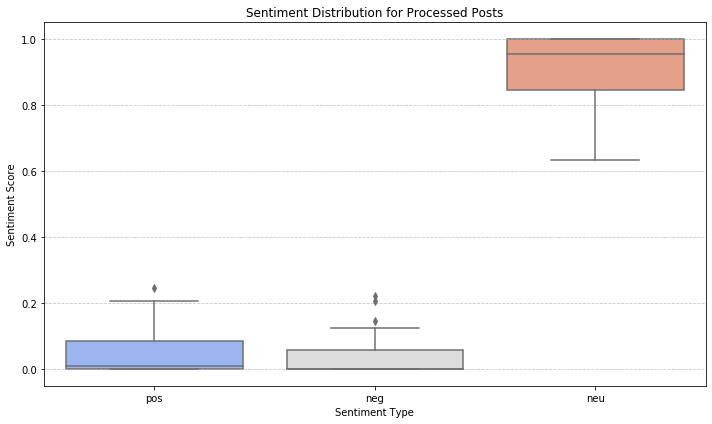

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure data contains the necessary columns
if not {'pos', 'neg', 'neu'}.issubset(df_machine_learning.columns):
    print("Error: DataFrame must contain 'pos', 'neg', and 'neu' columns.")
else:
    # Melt the DataFrame for visualization
    df_melted = pd.melt(
        df_machine_learning[['pos', 'neg', 'neu']], 
        var_name='Sentiment Type', 
        value_name='Sentiment Score'
    )

    # Plot sentiment distribution
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Sentiment Type', y='Sentiment Score', data=df_melted, palette='coolwarm')
    plt.title("Sentiment Distribution for Processed Posts")
    plt.xlabel("Sentiment Type")
    plt.ylabel("Sentiment Score")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


#### Provide a screenshot of the output (if necessary)

**(4 pts)**

If you ran your code in a VM, take a screenshot of the resulting graphical visualization and provide it here.

<img src="./" alt="Your screenshot is MISSING" />



---
# Step 5: Explanatory Data Analysis


### 5.1 What is the key insight from the tabularization?
**(3 pts)**

### 5.2 What is the key insight from the visualization?
**(3 pts)**

---
# Save your Notebook!